# Tutorial 3: PINN Assignment



The task of this assignment is to model product concentration in a batch reactor using both blackbox NN and a physics-informed NN and compare the results.

Consider the following system of consecutive first-order reactions:

<div style="text-align: center; margin:2rem;">
    <img src="r1.png">
</div>

The rate equations for the 3 components are as follows:

<div style="text-align: center; margin:2rem;">
    <img src="r2.png">
</div>

The typical concentration profiles for this system of reactions are shown below:

<div style="text-align: center; margin:2rem;">
    <img src="r3.png">
</div>

### Objective
It is required to model the concentration profile of component **R**.  
Consider the reaction rate constants **k1** & **k2** as unkown parameters to be learned when training the PINN and print their results.


## 1. Define the system parameters and exact solution (for model evaluation)

#### Import necessary Libraries (*this is complete*)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#### Define system parameters (*this is complete*)

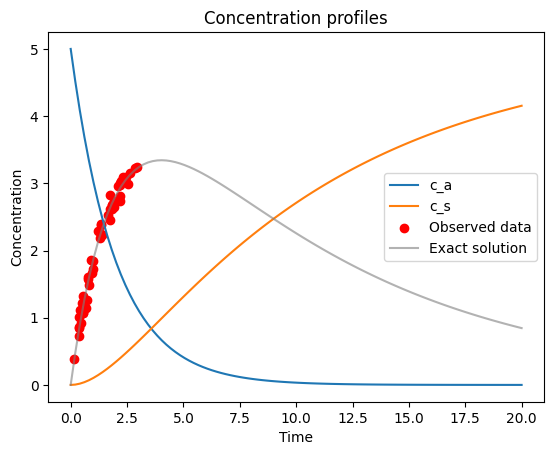

In [2]:
# System model
def exact_solution(c_a0, k1, k2, t):
    c_r = c_a0 * k1 * (torch.exp(-k1 * t) - torch.exp(-k2 * t)) / (k2 - k1)
    return c_r

# Create noisy observations
torch.manual_seed(12)
c_a0 = 5
k1 = 0.5
k2 = 0.1
t_obs = torch.rand(50).view(-1, 1) * 3
y_obs = exact_solution(c_a0, k1, k2, t_obs) + 0.1 *torch.randn_like(t_obs)

t_test = torch.linspace(0, 20, 100).view(-1, 1)
y_exact = exact_solution(c_a0, k1, k2, t_test)

# plot the data
def plot_observed_data():
    plt.scatter(t_obs, y_obs, label='Observed data', color='red')
    plt.plot(t_test, y_exact, label='Exact solution', color='grey', alpha=0.6)
    plt.legend()
    plt.show()


# helper functions to calculate c_a & c_s profiles
def calc_s_a(c_a0, k1, k2, t):
    c_a = c_a0 * torch.exp(-k1 * t)
    return c_a

def calc_s_c(c_a0, k1, k2, t):
    c_a = calc_s_a(c_a0, k1, k2, t)
    c_r = exact_solution(c_a0, k1, k2, t)
    c_s = c_a0 - c_a - c_r
    return c_s

# plot c_a & c_s profiles
plt.plot(t_test, calc_s_a(c_a0, k1, k2, t_test), label='c_a')
plt.plot(t_test, calc_s_c(c_a0, k1, k2, t_test), label='c_s')
plt.title('Concentration profiles')
plt.xlabel('Time')
plt.ylabel('Concentration')
plot_observed_data()

## 2. Neural Network model

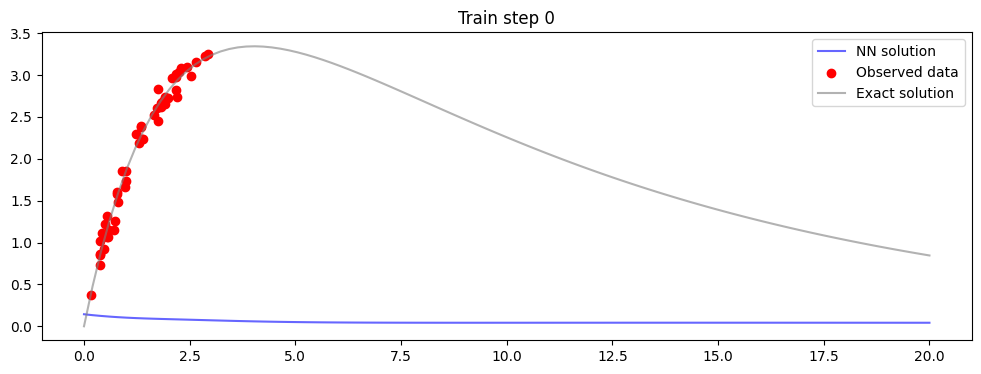

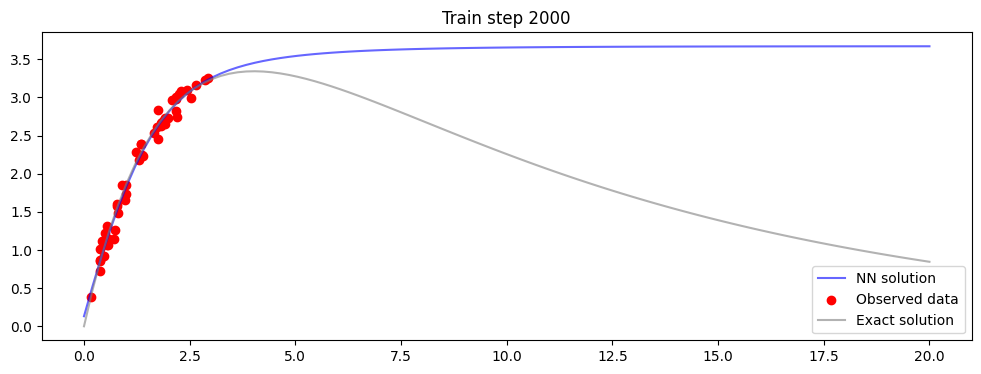

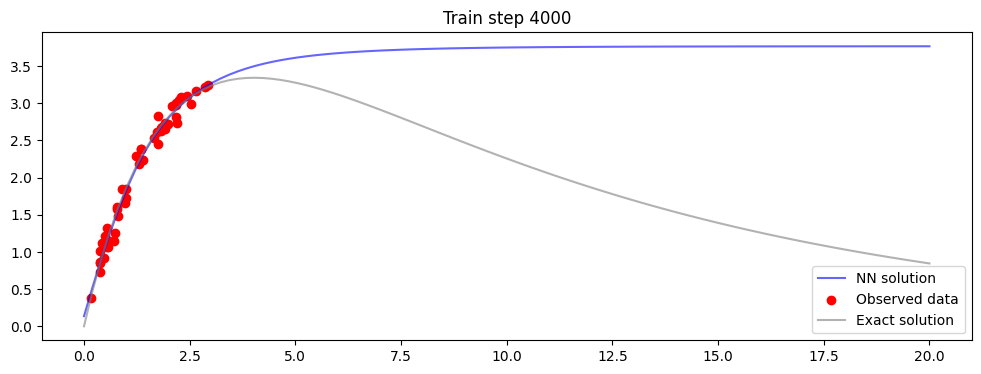

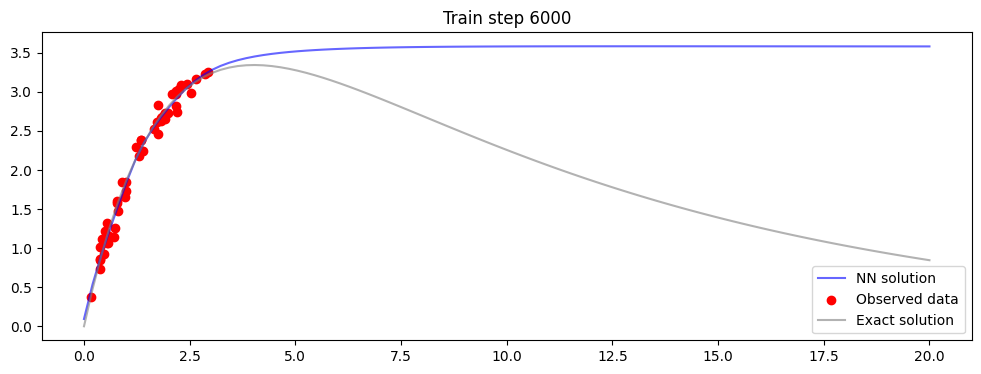

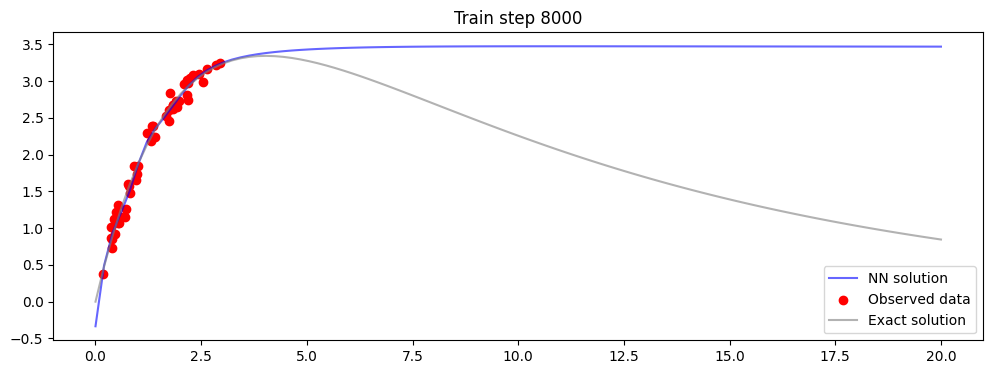

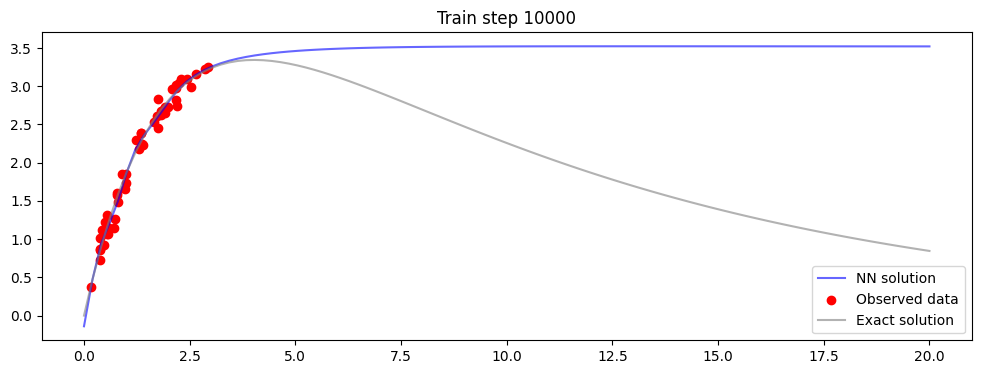

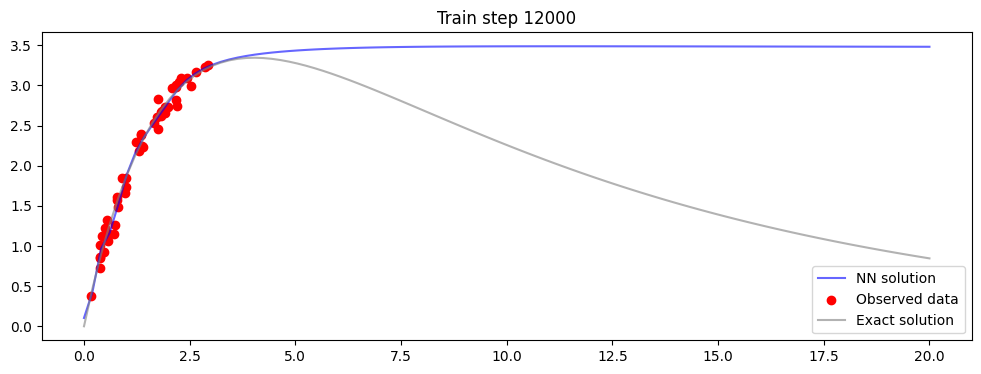

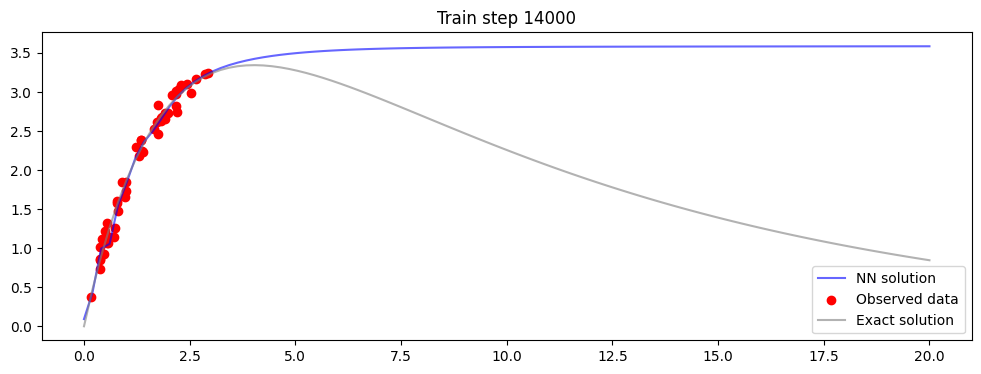

In [4]:
# create neural network class
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Tanh()):
        super().__init__()
        self.act_fn = act_fn

        # create the input layer
        self.input_layer = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the hidden layers
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.output_layer = nn.Linear(n_hidden, n_output)


    # define the forward pass of the network
    def forward(self, x):
       x = self.input_layer(x)
       x = self.hidden_layers(x)
       x = self.output_layer(x)
       return x


    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs + 1):
            optimizer.zero_grad()

            # compute the output
            y_pred = self(X)

            # compute the loss
            loss = loss_fn(y_pred, y)

            # backpropagate the loss and update the weights
            loss.backward()
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(t_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(t_test[:,0], y_pred[:,0], label='NN solution', color='blue', alpha=0.6)
                plot_observed_data()


# create a neural network instance
model_nn = NN(1, 1, 32, 3)

# train the NN
model_nn.fit(t_obs, y_obs, 15001, lr=1e-3)



## 3. PINN model

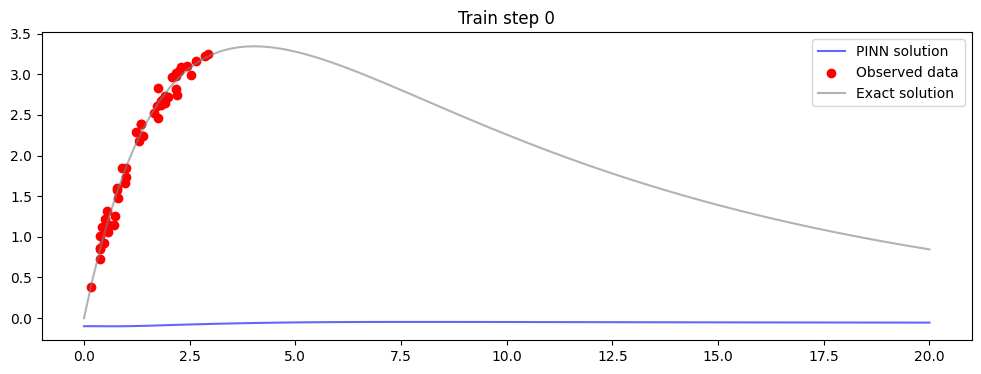

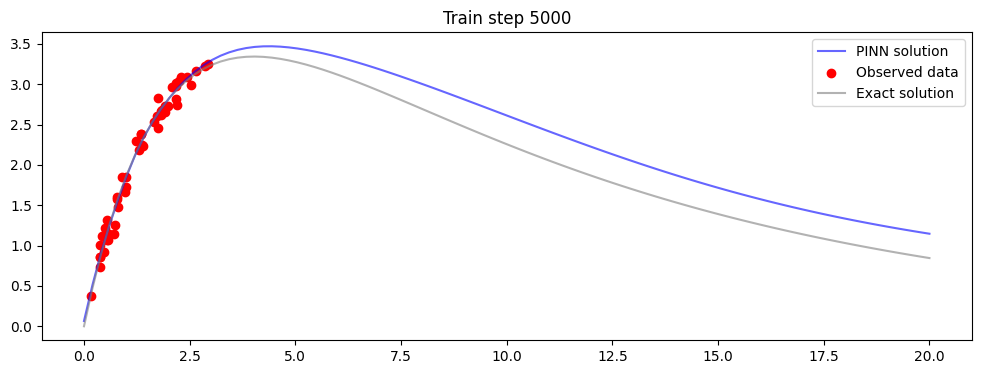

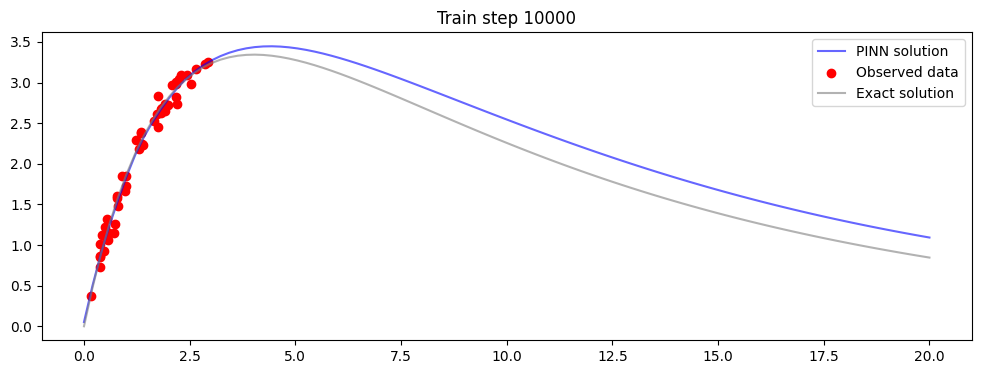

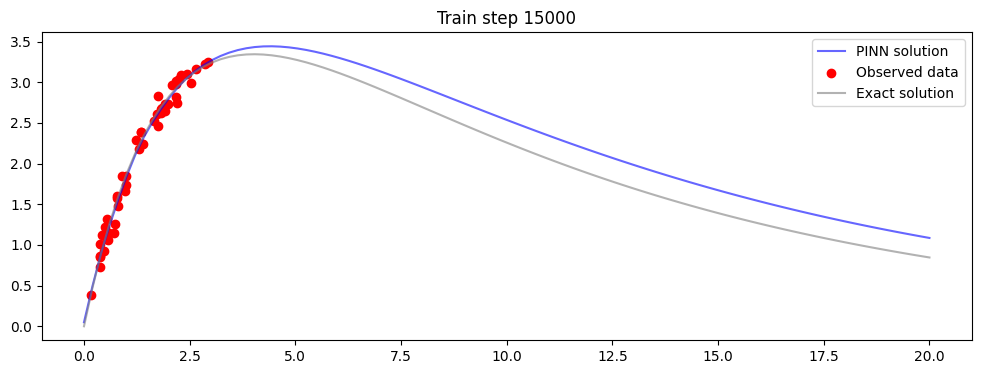

In [5]:
# create neural network class
class PINN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Tanh()):
        super().__init__()
        self.act_fn = act_fn

        # create the input layer
        self.input_layer = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the hidden layers
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.output_layer = nn.Linear(n_hidden, n_output)

        # physical parameters to be learned
        self.k1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.k2 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    # define the forward pass of the network
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):

        t_physics = torch.linspace(0, 20, 300).view(-1, 1).requires_grad_(True)
        lambda_data = 1
        lambda_phys = 1

        # optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs + 1):
            # reset the gradients back to zero
            optimizer.zero_grad()

            # compute the output
            y_pred = self(X)

            # compute data loss
            loss_data = loss_fn(y_pred, y)

            # compute physics loss
            u = self.forward(t_physics)
            dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
            loss_phys = loss_fn(self.k1*calc_s_a(c_a0, self.k1, self.k2, t_physics) - dudt - self.k2*u, torch.zeros_like(dudt))

            # compute the total loss
            loss = lambda_data*loss_data + lambda_phys*loss_phys

            # backpropagate the loss and update the weights
            loss.backward()
            optimizer.step()


            # plot the result as training progresses
            if epoch % 5000 == 0:
                y_pred = self.forward(t_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(t_test[:,0], y_pred[:,0], label='PINN solution', color='blue', alpha=0.6)
                plot_observed_data()

model_pinn = PINN(1, 1, 32, 3)

# train the NN
model_pinn.fit(t_obs, y_obs, 15000, lr=1e-3)


<details>
    <summary>Hint 💡</summary>
    <ul>
        <li>Try different number of neurons and hidden layers</li>
        <li>Try different learning rates</li>
        <li>Try different regularization weights for the physical and data losses</li>
    </ul>
</details>